In [174]:
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from flask import request
from scipy import optimize
from scipy import integrate

In [175]:
mpl.rcParams['figure.figsize'] = (16,9)
pd.set_option('display.max_rows',500)
sns.set(style="darkgrid")

In [176]:
df_analyse = pd.read_csv('../data/processed/COVID_small_flat_table.csv', sep=';')
df_analyse.sort_values('date', ascending=True).head()

,date,Italy,US,Spain,Germany,"Korea, South"
0,2020-01-22,0,1,0,0,1
1,2020-01-23,0,1,0,0,1
2,2020-01-24,0,2,0,0,2
3,2020-01-25,0,2,0,0,2
4,2020-01-26,0,5,0,0,3


In [177]:
N0 = 1000000
beta = 0.4
gamma = 0.1
# reproduction number beta/gamma

I0 = df_analyse.Germany[35] # Initial infected people
S0 = N0-I0 # Initial suspected population
R0 = 0 # Initial recoverd population

In [178]:
def SIR_model(SIR, beta, gamma):
    '''
    Simple SIR model implementation.
    S: Suspected population
    I: Infected population
    R: Recoered population
    beta: rate of infection
    gamma: rate of recovery
    as per slides: ds+dI+dR = 0 and S+R+I=N (total population)
    
    Make a note tht in this model a recovered person can not get infected again.
    '''
    
    S,I,R = SIR
    dS_dt = -beta*S*I/N0
    dI_dt = beta*S*I/N0 - gamma*I
    dR_dt = gamma*I
    
    return([dS_dt, dI_dt, dR_dt])


In [179]:
SIR = np.array([S0,I0,R0])
propagation_rates = pd.DataFrame(columns={'susceptible':S0,
                                         'infected':I0,
                                         'recovered':R0})

for each_t in np.arange(180):
    new_delta_vec = SIR_model(SIR, beta, gamma)
    
    SIR = SIR + new_delta_vec
    
    propagation_rates = propagation_rates.append({'susceptible':SIR[0],
                                         'infected':SIR[1],
                                         'recovered':SIR[2]}, ignore_index=True)

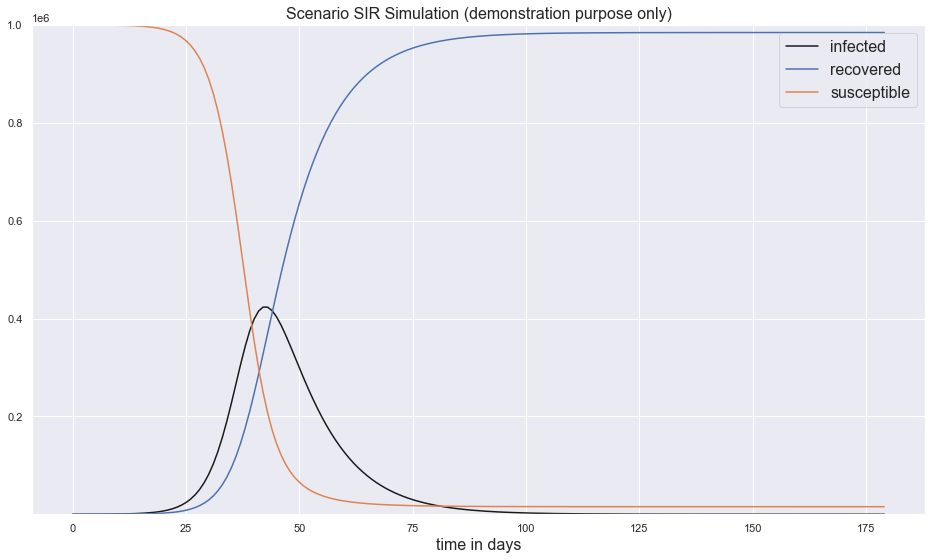

In [180]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(propagation_rates.index, propagation_rates.infected, label='infected', color ='k')
ax1.plot(propagation_rates.index, propagation_rates.recovered, label='recovered')
ax1.plot(propagation_rates.index, propagation_rates.susceptible, label='susceptible')


ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Scenario SIR Simulation (demonstration purpose only)', size = 16)
ax1.set_xlabel('time in days', size =16)
ax1.legend(loc='best',
          prop={'size':16});

## Fitting the parameters of SIR model

In [181]:
df_analyse = pd.read_csv('../data/processed/COVID_full_flat_table.csv', sep=';')
#df_analyse.sort_values('date', ascending=True).tail()

In [182]:
ydata = np.array(df_analyse.US[35:])
t = np.arange(len(ydata))

In [167]:
I0 = ydata[0]
N0 = 5000000
S0 = N0 - I0
R0 = 0
beta = 0.4
gamma = 0.1

In [168]:
def SIR_model_fit(SIR, time, beta, gamma):
    '''
    Simple SIR model implementation.
    S: Suspected population
    I: Infected population
    R: Recoered population
    beta: rate of infection
    gamma: rate of recovery
    time: for integral as define in odeint function of scipy.integrate
    as per slides: ds+dI+dR = 0 and S+R+I=N (total population)
    
    Make a note tht in this model a recovered person can not get infected again.
    '''
    
    S,I,R = SIR
    dS_dt = -beta*S*I/N0
    dI_dt = beta*S*I/N0 - gamma*I
    dR_dt = gamma*I
    
    return dS_dt, dI_dt, dR_dt


In [169]:
def fit_odeint(x, beta, gamma):
    return integrate.odeint(SIR_model_fit, (S0, I0, R0), t, args=(beta, gamma))[:,1]  #we are only fetching dI

In [170]:
#popt=[0.4,0.1]
#fit_odeint(t, *popt)

In [171]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata, maxfev=5000)
perr = np.sqrt(np.diag(pcov))

print('standard deviation error: ', str(perr), 'start infect: ',ydata[0])
print('optimal parameters -> beta: ', popt[0], 'and gamma: ',popt[1])

C:\Users\Shashank Mishra\.conda\envs\EDA\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

C:\Users\Shashank Mishra\.conda\envs\EDA\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Shashank Mishra\.conda\envs\EDA\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Shashank Mishra\.conda\envs\EDA\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Shashank Mishra\.conda\envs\EDA\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.



standard deviation error:  [0.00132681 0.00051695] start infect:  15
optimal parameters -> beta:  0.10447847778354198 and gamma:  -0.0005817317911260637


In [172]:
#print(popt)
#print(t)
fitted = fit_odeint(t, *popt)

188
188


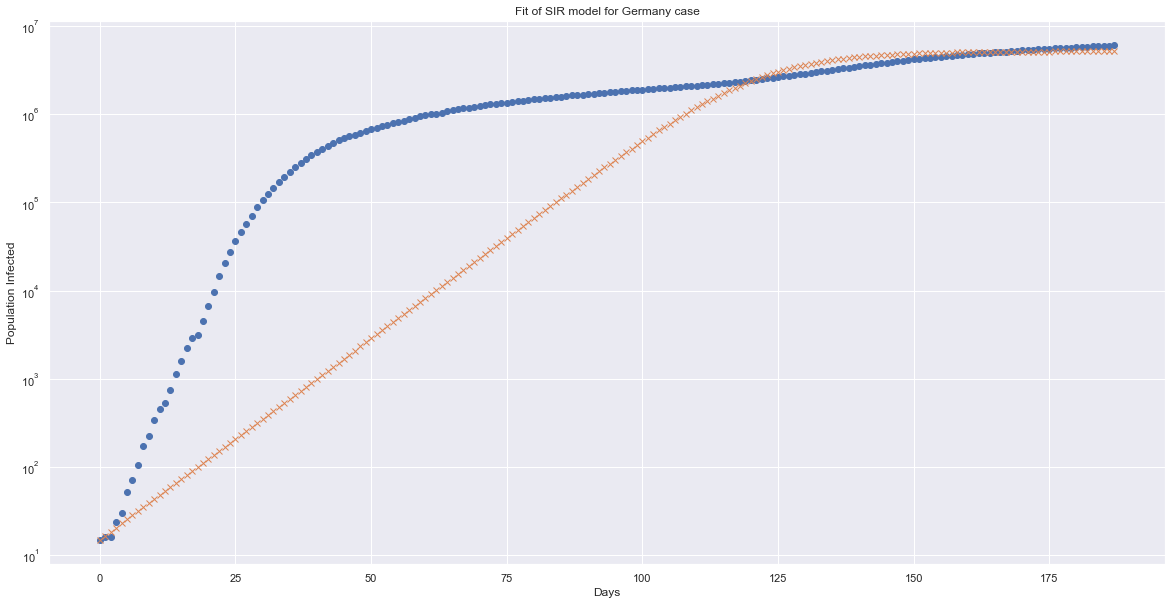

optimal parameters -> beta:  0.10447847778354198 and gamma:  -0.0005817317911260637
Basic Reproduction Number R0  -179.5990512763657


In [173]:
plt.figure(figsize=(20,10))
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted, 'x')
plt.title("Fit of SIR model for Germany case")
plt.ylabel("Population Infected")
plt.xlabel("Days")
plt.show()
print('optimal parameters -> beta: ', popt[0], 'and gamma: ',popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])

## Dynamic beta in SIR (infection rate)

In [229]:
t_initial = 21
t_intro_measure = 30
t_hold = 50
t_relax = 21
beta_max = 0.4
beta_min = 0.2
gamma = 0.1

pd_beta = np.concatenate((np.array(t_initial*[beta_max]),
                         np.linspace(beta_max, beta_min, t_intro_measure),
                         np.array(t_hold*[beta_min]), 
                         np.linspace(beta_min, beta_max, t_relax)))

pd_beta

array([0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.39310345, 0.3862069 , 0.37931034,
       0.37241379, 0.36551724, 0.35862069, 0.35172414, 0.34482759,
       0.33793103, 0.33103448, 0.32413793, 0.31724138, 0.31034483,
       0.30344828, 0.29655172, 0.28965517, 0.28275862, 0.27586207,
       0.26896552, 0.26206897, 0.25517241, 0.24827586, 0.24137931,
       0.23448276, 0.22758621, 0.22068966, 0.2137931 , 0.20689655,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2    

In [230]:
SIR = np.array([S0,I0,R0])
propagation_rates = pd.DataFrame(columns={'susceptible':S0,
                                         'infected':I0,
                                         'recovered':R0})

for each_beta in pd_beta:
    new_delta_vec = SIR_model(SIR, each_beta, gamma)
    
    SIR = SIR + new_delta_vec
    
    propagation_rates = propagation_rates.append({'susceptible':SIR[0],
                                         'infected':SIR[1],
                                         'recovered':SIR[2]}, ignore_index=True)

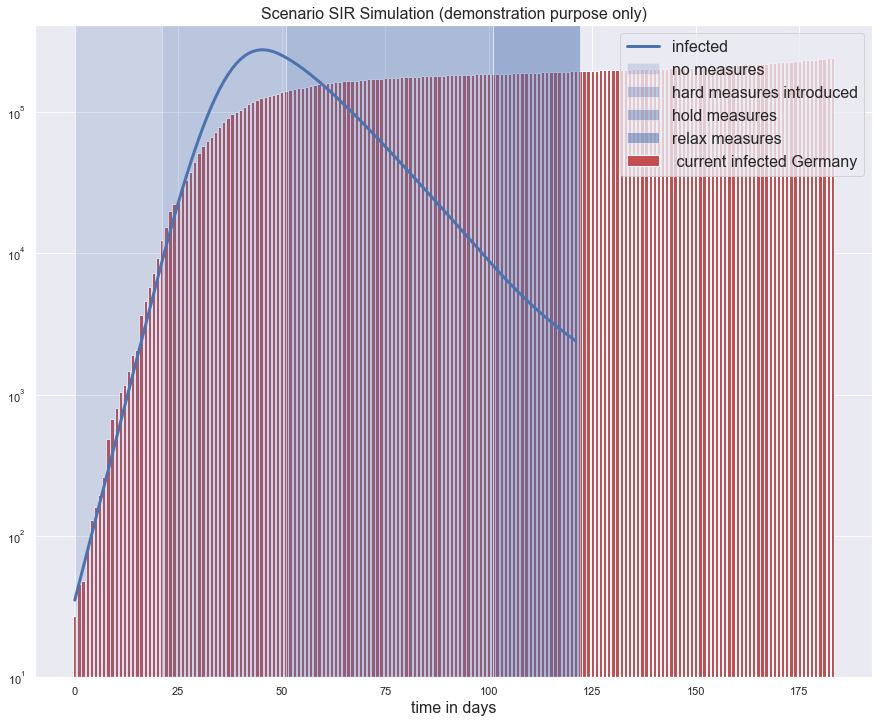

<Figure size 1440x720 with 0 Axes>

In [231]:
fig, ax1 = plt.subplots(1,1)
fig.set_figheight(12)
fig.set_figwidth(15)
plt.figure(figsize=(20,10))
ax1.plot(propagation_rates.index, propagation_rates.infected, label='infected', linewidth=3)
#ax1.plot(propagation_rates.index, propagation_rates.recovered, label='recovered')
#ax1.plot(propagation_rates.index, propagation_rates.susceptible, label='susceptible')


t_phases=np.array([t_initial,t_intro_measure,t_hold,t_relax]).cumsum()
ax1.bar(np.arange(len(ydata)),ydata, width=0.8,label=' current infected Germany',color='r')
ax1.axvspan(0,t_phases[0], facecolor='b', alpha=0.2,label='no measures')
ax1.axvspan(t_phases[0],t_phases[1], facecolor='b', alpha=0.3,label='hard measures introduced')
ax1.axvspan(t_phases[1],t_phases[2], facecolor='b', alpha=0.4,label='hold measures')
ax1.axvspan(t_phases[2],t_phases[3], facecolor='b', alpha=0.5,label='relax measures')
#ax1.axvspan(t_phases[3],len(propagation_rates.infected), facecolor='b', alpha=0.6,label='repead hard measures')

ax1.set_ylim(10, 1.5*max(propagation_rates.infected))
ax1.set_yscale('log')
ax1.set_title('Scenario SIR Simulation (demonstration purpose only)', size = 16)
ax1.set_xlabel('time in days', size =16)
ax1.legend(loc='best',
          prop={'size':16});